### ローソク足の描画
1分のローソク足データを用いて、1時間ごとのチャートを描画する。

### 正解ラベルの付与
* 1分のローソク足をダウンサンプリングし、1時間、4時間、1日、3日のローソク足チャートを作成する。このデータを用いて、下降/停滞/上昇の3パターンに分類する。
* ここでは、2015年から2020年までのデータを用いて、変化量の分布を推定する。本来、未来の値は利用できないが、傾向分析により得られた結果という位置づけで利用する。
* また、変化量は、推定した分布（正規分布）に従うものとし、人手で決めた閾値で分類する。今回は、閾値を0.3とし、以下のように分類した。

| パターン | 条件 | クラス | ラベル |
| :--- | :--- | :--- | :--- |
| 下降 | 変化量が-0.3以下 | 0 | down |
| 停滞 | 変化量が-0.3より大きく0.3より小さい | 1 | stay |
| 上昇 | 変化量が0.3以上 | 2 | up |

In [1]:
import os
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 変化量の推定
def estimate_diff(df):
    params = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}

    # オリジナルデータの取得
    original_index = df.index.to_series()
    # ダウンサンプリングしたローソク足の作成
    dfs = {
        'hour':      df.resample('H').agg(params).dropna(),  # 1時間のローソク足チャート
        'one_sixth': df.resample('4H').agg(params).dropna(), # 4時間のローソク足チャート
        '1day':      df.resample('D').agg(params).dropna(),  # 1日のローソク足チャート
        '3days':     df.resample('3D').agg(params).dropna(), # 3日のローソク足チャート
    }
    # 重み係数（ヒューリスティックに決定）
    weights = {
        'hour':      0.30,
        'one_sixth': 0.50,
        '1day':      0.15,
        '3days':     0.05,
    }
    # 変化量の計算
    diff_func = lambda target: target['close'].pct_change(1).shift(-1).dropna()
    # データごとに変化量を計算
    diffs = {key: diff_func(target) for key, target in dfs.items()}
    # インデックスの作成
    indices = pd.concat([series.index.to_series() for series in diffs.values()]).drop_duplicates().sort_values()
    # データフレームの作成
    columns = list(dfs.keys())
    target_df = pd.DataFrame(data=np.nan, index=indices, columns=columns)

    # データが存在する部分を更新
    for key, series in diffs.items():
        target = series.index.to_series().apply(lambda time: time.strftime('%Y/%m/%d %H:%M'))
        target_df.loc[target, key] = series

    # hourを基準にNaNの行を削除
    target_df = target_df.dropna(subset=['hour'])
    # 線形補間
    target_df = target_df.interpolate()
    # 重み付け和により変化量を推定
    for key in columns:
        target_df['weighted_{}'.format(key)] = weights[key] * target_df[key]
    series = target_df[['weighted_{}'.format(key) for key in columns]].sum(axis=1)

    return series

# ヒストグラムの描画
def plot_histogram(series, threshold=0.3):
    # ヒストグラムの描画
    series_std = (series - series.mean()) / series.std()
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Distribution of pct_change')
    ax.set_xlabel('pct_change')
    ax.set_ylabel('frequency')
    ax.set_ylim(0, 1.0)
    ax.grid(False)
    judge = series_std.abs() < threshold
    ax.hist(series_std,        bins=500, range=(-5,5), density=True, alpha=0.3, color='b')
    ax.hist(series_std[judge], bins=500, range=(-5,5), density=True, alpha=0.3, color='r')
    matched = series_std[judge].count()
    total = series_std.count()
    print('matched / total: {} / {} ({:.3%})'.format(matched, total, matched / total))
    
    return ax

In [3]:
class CreateDataset():
    def __init__(self, diff, root_dir='chart'):
        self.root_dir = root_dir
        self.mean = diff.mean()
        self.std = diff.std()
        # ダウンサンプリング用の関数
        self.downsampling_func = lambda df, pattern: df.resample('H').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}).dropna()
        self.get_middle_dir = lambda time: time.strftime('%Y/%m')
        
    def __get_output_path(self, time):
        output_filename = 'fig{}.png'.format(time.strftime('%Y%m%d%H%M'))
        output_path = os.path.join(self.root_dir, self.get_middle_dir(time), output_filename)
        
        return output_path

    # 変化量の推定
    def estimate_diff(self, df):
        params = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}

        # オリジナルデータの取得
        original_index = df.index.to_series()
        # ダウンサンプリングしたローソク足の作成
        dfs = {
            'hour':      self.downsampling_func(df, 'H'),  # 1時間のローソク足チャート
            'one_sixth': self.downsampling_func(df, '4H'), # 4時間のローソク足チャート
            '1day':      self.downsampling_func(df, 'D'),  # 1日のローソク足チャート
            '3days':     self.downsampling_func(df, '3D'), # 3日のローソク足チャート
        }
        # 重み係数（ヒューリスティックに決定）
        weights = {
            'hour':      0.30,
            'one_sixth': 0.50,
            '1day':      0.15,
            '3days':     0.05,
        }
        # 変化量の計算（NaNは平均値とする）
        diff_func = lambda target: target['close'].pct_change(1).shift(-1).fillna(self.mean)
        # データごとに変化量を計算
        diffs = {key: diff_func(target) for key, target in dfs.items()}
        # インデックスの作成
        indices = pd.concat([series.index.to_series() for series in diffs.values()]).drop_duplicates().sort_values()
        # データフレームの作成
        columns = list(dfs.keys())
        target_df = pd.DataFrame(data=np.nan, index=indices, columns=columns)

        # データが存在する部分を更新
        for key, series in diffs.items():
            target = series.index.to_series().apply(lambda time: time.strftime('%Y/%m/%d %H:%M'))
            target_df.loc[target, key] = series

        # hourを基準にNaNの行を削除
        target_df = target_df.dropna(subset=['hour'])
        # 線形補間
        target_df = target_df.interpolate()
        # 重み付け和により変化量を推定
        for key in columns:
            target_df['weighted_{}'.format(key)] = weights[key] * target_df[key]
        series = target_df[['weighted_{}'.format(key) for key in columns]].sum(axis=1)

        return series

    # チャート出力用関数
    def plot_chart(self, df):
        indices = self.downsampling_func(df, 'H').index
        # 出力先のディレクトリ作成
        date = indices.to_series().apply(lambda time: self.get_middle_dir(time))
        dirs = date.drop_duplicates().to_list()
        for dirname in dirs:
            dir_path = os.path.join(self.root_dir, dirname)
            os.makedirs(dir_path, exist_ok=True)
        # figureの生成
        fig = mpf.figure(style='yahoo', figsize=(3, 3))
        # 余白の設定
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Axesの生成
        ax = fig.add_subplot(1, 1, 1)
        # plot
        for idx in indices:
            print(idx.strftime('%Y/%m/%d %H:%M'))
            mpf.plot(df[idx.strftime('%Y-%m-%d %H')], type='candle', ax=ax, tight_layout=True)
            # ラベルを削除
            ax.grid(False)
            ax.axes.xaxis.set_ticks([])
            ax.axes.yaxis.set_ticks([])
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            ax.axis('off')
            fig.savefig(self.__get_output_path(idx))
            ax.clear()

        plt.close(fig)

    # チャートから正解ラベルを生成
    def create_groundtruth(self, df, threshold=0.3):
        # 変化量の取得
        series = self.estimate_diff(df)
        series_std = (series - self.mean) / self.std
        # DataFrameの用意
        indices = self.downsampling_func(df, 'H').index
        ret_df = pd.DataFrame(index=indices, columns=['path', 'class', 'label'])
        ret_df['path'] = indices.to_series().apply(lambda time: self.__get_output_path(time))
        # 初期化（下降）
        ret_df['class'] = 0
        ret_df['label'] = 'down'
        # 「停滞する」部分の抽出
        judge = series_std.abs() < threshold
        ret_df.loc[judge, 'class'] = 1
        ret_df.loc[judge, 'label'] = 'stay'
        # 「上昇する」部分の抽出
        judge = series_std >= threshold
        ret_df.loc[judge, 'class'] = 2
        ret_df.loc[judge, 'label'] = 'up'

        return ret_df
    
# データセットの出力
def output_dataset(df, output_filename):
    df.to_csv(output_filename, header=True, index=False)

In [4]:
# データの読み込み
df = pd.read_csv('csv/concat_USDJPY2015_2020.csv', index_col='datetime', parse_dates=True)
create_chart = True

In [5]:
# ================
# データセット作成
# ================
threshold = 0.3
train_output_filename = 'train_dataset.csv'
test_output_filename = 'test_dataset.csv'
train_df = df[:'2019'].copy()
test_df = df['2020'].copy()

mean: -1.471395890744751e-05
std:  1.250206681159220e-03
matched / total: 11748 / 37231 (31.554%)


<AxesSubplot:title={'center':'Distribution of pct_change'}, xlabel='pct_change', ylabel='frequency'>

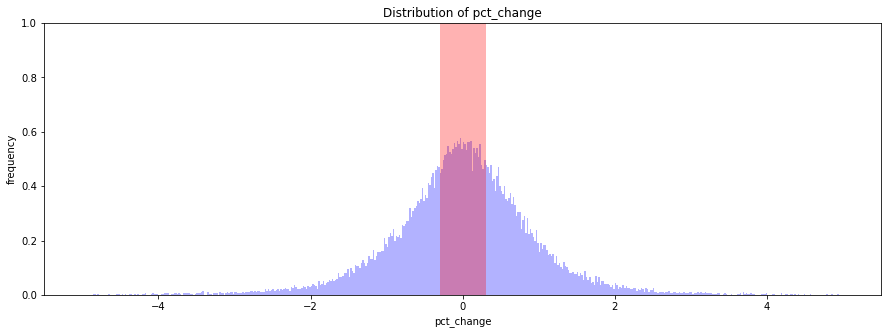

In [6]:
# データの推定
series = estimate_diff(df)
print('mean: {:.15e}'.format(series.mean()))
print('std:  {:.15e}'.format(series.std()))
plot_histogram(series, threshold)

In [7]:
# インスタンス生成
creater = CreateDataset(series)
# 正解ラベルの生成
output_train_df = creater.create_groundtruth(train_df, threshold)
output_test_df = creater.create_groundtruth(test_df, threshold)
output_dataset(output_train_df, train_output_filename)
output_dataset(output_test_df, test_output_filename)

if create_chart:
    # 時間のかかる処理
    creater.plot_chart(train_df)
    creater.plot_chart(test_df)

In [8]:
# データセットのパスの確認
for filename in [train_output_filename, test_output_filename]:
    out_df = pd.read_csv(filename)

    for row in out_df.itertuples():
        if not os.path.exists(row.path):
            print('{} does not exist'.format(row.path))

matched / total: 11898 / 30992 (38.391%)


<AxesSubplot:title={'center':'Distribution of pct_change'}, xlabel='pct_change', ylabel='frequency'>

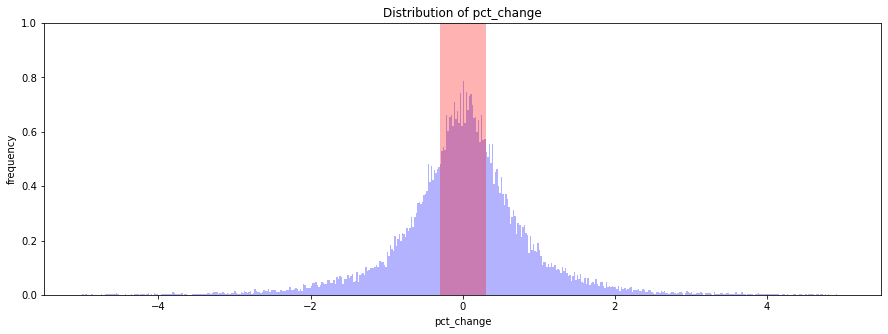

In [9]:
plot_histogram(creater.estimate_diff(train_df))

matched / total: 2549 / 6240 (40.849%)


<AxesSubplot:title={'center':'Distribution of pct_change'}, xlabel='pct_change', ylabel='frequency'>

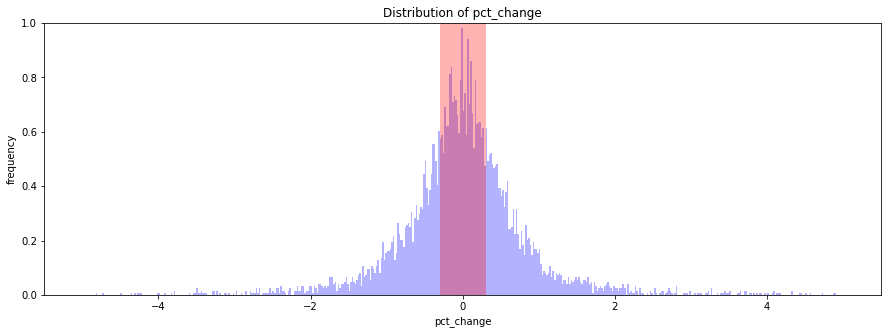

In [10]:
plot_histogram(creater.estimate_diff(test_df))